# CellRank2 analysis of TE001
CellRank2 analysis of TE001 using CellRank2 CytoTRACE Kernel

### a) Import packages and data
Setup path to data-containing folder and savings and parameters


In [1]:
# a.1) setup path to data-containing folder and savings and parameters
h5ad_path = "/Users/AlexanderWang/Desktop/ics-rebuttal/TE001-h5ad/"
figures_dir = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/"
figures_dir_CytoTRACE = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/"
figures_dir_TE001 = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/"
name_prefix = "TE001_"

n_macro_CytoTRACE = 8 # number of macrostates 
# scale_data = True
scale_data = False

Import packages and set markers of interest

In [2]:
# a.2) packages
import sys
import anndata
import cellrank as cr
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 


Load counts data and metadata for TE001. Setup UMAP coordinates for UMAP visualization 

In [3]:
# a.3) load counts data (exported from Seurat@RNA assay)
counts_h5ad = h5ad_path + "TE001-counts.h5ad"
adata = sc.read_h5ad(counts_h5ad) # load in object

# a.4) load metadata for TE001 
metadata_csv = h5ad_path + "TE001-metadata-umap-and-clusters-for-paper.csv"
metadata = pd.read_csv(metadata_csv)

# a.6) process metadata in adata
specified_columns = ["cell_id", "nCount_RNA", "nFeature_RNA", "mt_percent", "cytotrace_score.ges",
                     "cytotrace_gcs.ges", "S.Score", "G2M.Score", "Phase", "seurat_clusters", "singleR_labels", "stemness_index.ges"]

adata.obs = adata.obs[specified_columns]
cells_to_analyze = metadata['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object


adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category') # clusters as categorical variable

# a.7) set UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1_scanpy','UMAP_2_scanpy']]) 
adata.obsm['X_umap'] = umap_coordinates

# a.9) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

print("adata contains the counts for the TE001 dataset")
counts = adata.raw.to_adata() # the adata already contains the counts matrix

adata contains the counts for the TE001 dataset


Show Lgr4 and Lgr5 marker genes

UMAP showing Lgr4 and Lgr5 expression


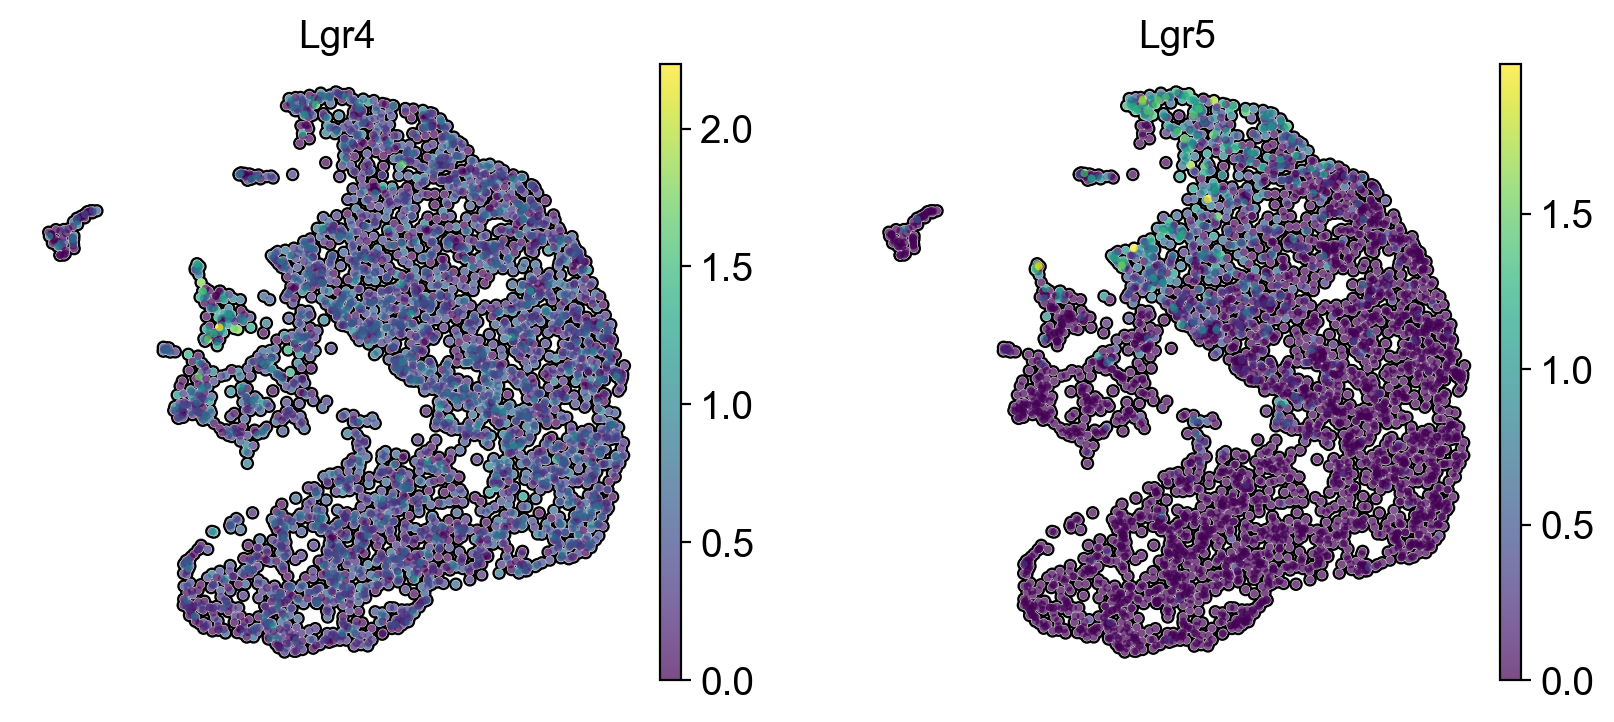

In [4]:
# a.8) display specific marker genes
log_expression = adata.copy()
sc.pp.normalize_total(log_expression, target_sum=1e4)
sc.pp.log1p(log_expression)

print("UMAP showing Lgr4 and Lgr5 expression")
sc.pl.umap(log_expression,color=["Lgr4","Lgr5"], use_raw=False, cmap='viridis',add_outline=True)

Add log-transformed expression (log1p) of selected genes to the `obs` slot of `adata` for later use and plotting.

In [5]:
# add log1p-transformed expression to selected genes to the adata  
log_selected_df = log_expression[:,['Lgr4','Lgr5','Atad2','Mki67']].to_df()
log_selected_df = log_selected_df.rename(columns={'Lgr4':'log(Lgr4)', 'Lgr5':'log(Lgr5)', 'Atad2':'log(Atad2)', 'Mki67':'log(Mki67)'})
adata.obs = pd.merge(adata.obs, log_selected_df, left_index=True, right_index=True, how='left') # merge metadata and include into log_selected_df

Show clusters at gene expression, clusters at protein activity, precomputed cytotrace score (with Cytotrace, not CellRank) and stemness index

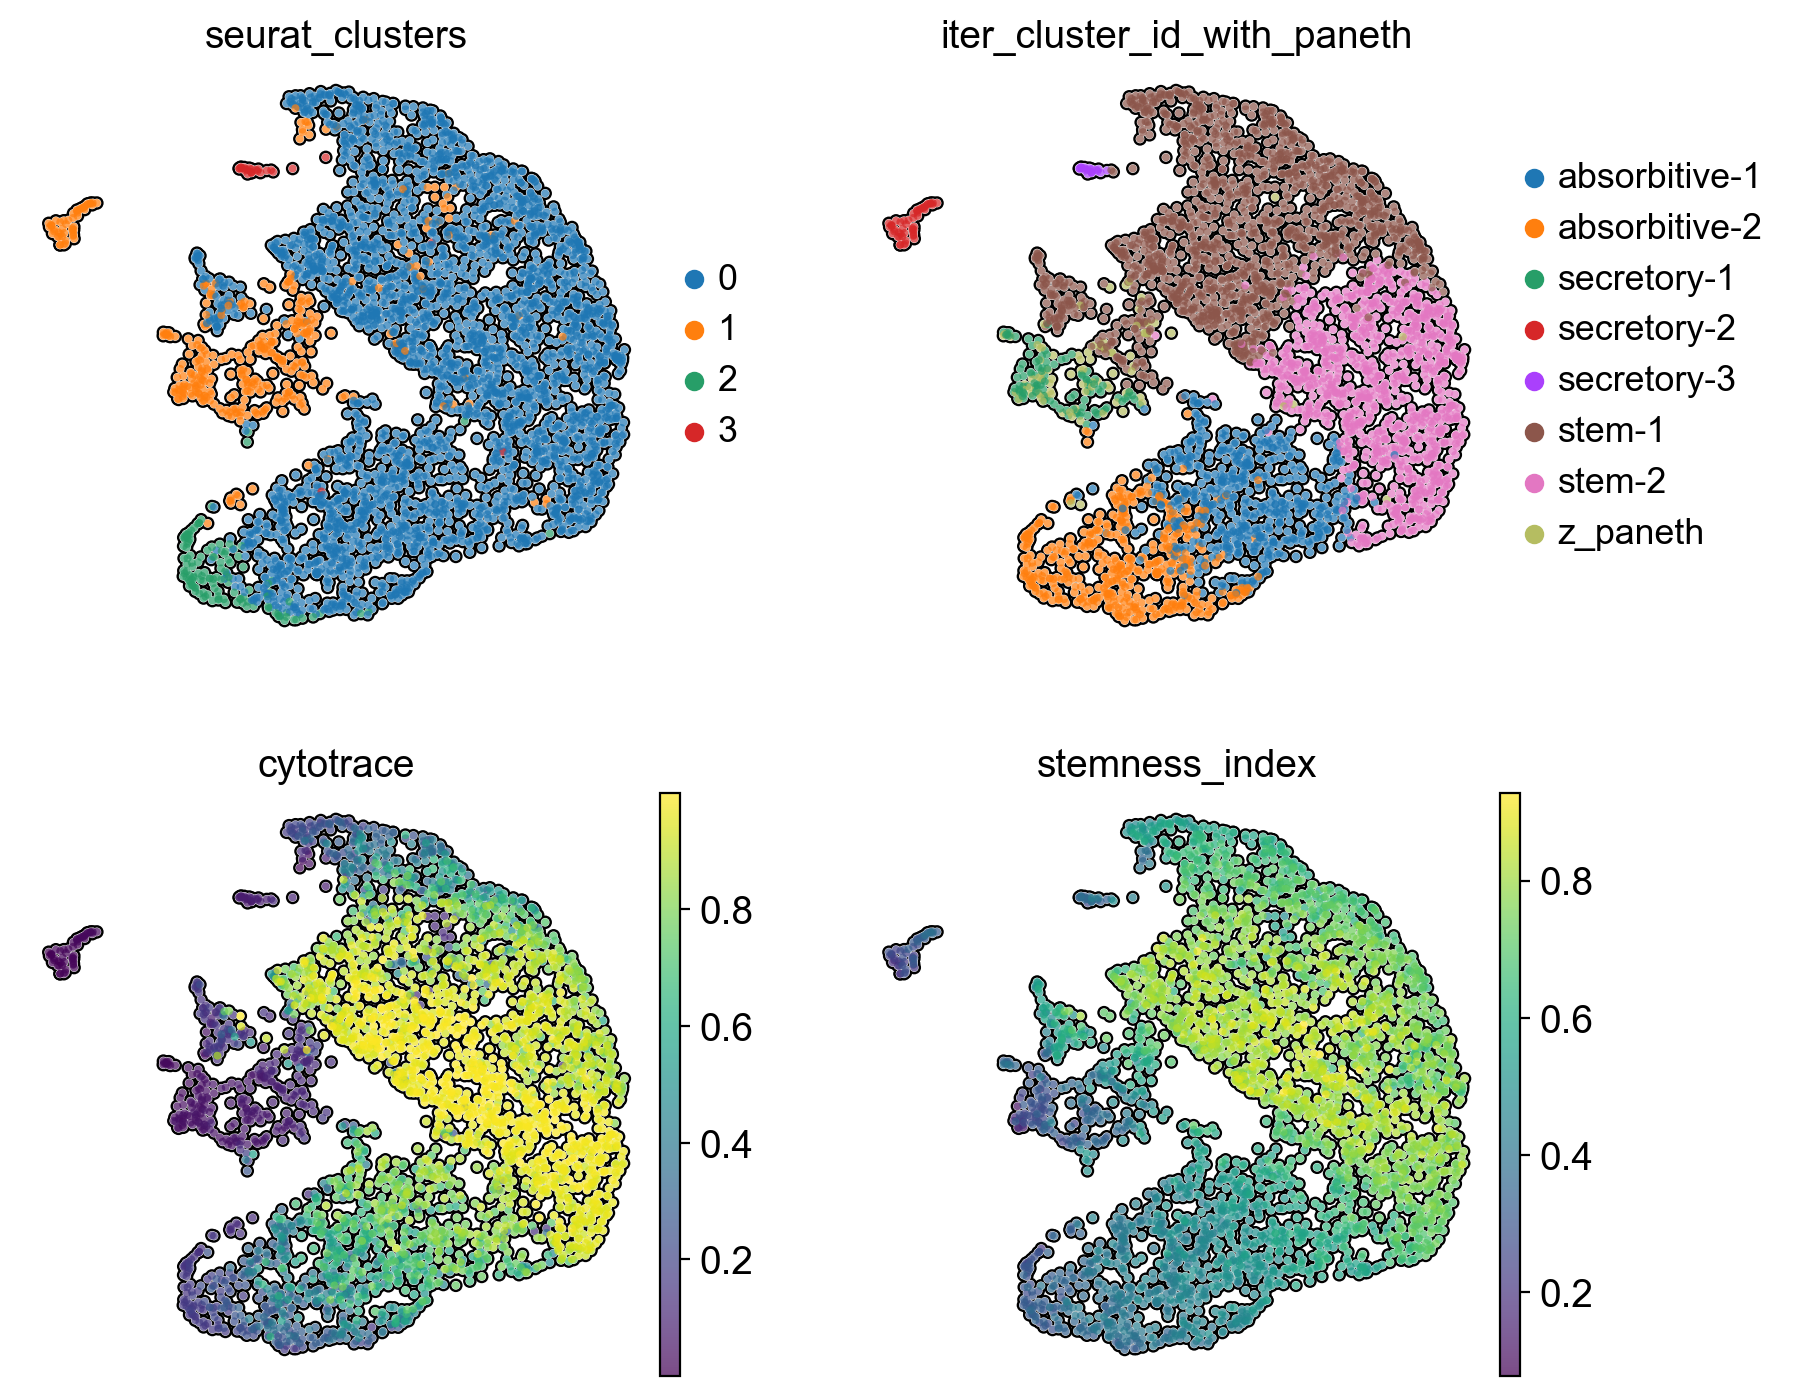

In [6]:
sc.pl.umap(adata, color=["seurat_clusters","iter_cluster_id_with_paneth","cytotrace","stemness_index"], ncols=2, add_outline=True)

Preprocess data for CellRank2 analysis

In [7]:
### b) Preprocess the data 
print("Preprocessing counts matrix for CellRank 2 analysis")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

if scale_data:
    adata_scale = anndata.AnnData(adata.X.copy())
    sc.pp.scale(adata_scale, zero_center=True, max_value=10)
    adata_scale.to_df()
    sc.tl.pca(adata_scale, random_state=0)
    adata.obsm['X_pca'] = adata_scale.obsm['X_pca'].copy()
    del adata_scale
else:
    sc.tl.pca(adata, random_state=0)

sc.pp.neighbors(adata, random_state=0, n_neighbors = 91)

Preprocessing counts matrix for CellRank 2 analysis


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### CellRank2 analysis with CytoTRACE Kernel
Import CellRank2 kernel, compute CytoTRACE score with CellRank (sparse), and compute transition matrix for CellRank2 analysis

In [8]:
##########################################################################################################
##########################################################################################################
### CellRank2 analysis with CytoTRACE Kernel
##########################################################################################################
##########################################################################################################

### c) CytoTRACE kernel
# c.1) Setup kernel
print("Working with CytoTRACE kernel")
from cellrank.kernels import CytoTRACEKernel
import scvelo as scv
# CytoTRACE by default uses imputed data - a simple way to compute
# k-NN imputed data is to use scVelo's moments function.
# However, note that this function expects `spliced` counts because
# it's designed for RNA velocity, so we're using a simple hack here:
if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
    adata.layers['spliced'] = adata.X
    adata.layers['unspliced'] = adata.X
scv.pp.moments(adata) # hack for CytoTRACEkernel

ctk = CytoTRACEKernel(adata) # initialize the CellRank2 kernel

# c.2) compute transition matrix
ctk = ctk.compute_cytotrace().compute_transition_matrix(threshold_scheme="soft",nu=0.5) # compute transition matrix


Working with CytoTRACE kernel
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `15385` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)
Computing transition matrix based on pseudotime


  0%|          | 0/3656 [00:00<?, ?cell/s]

    Finish (0:00:06)


Initialize folder collecting CytoTRACE figures

In [9]:
# c.2) Set up figure directories
if os.path.exists(figures_dir):
    print("'figures_dir' directory already exists")
else:
    os.mkdir(figures_dir)

if os.path.exists(figures_dir_CytoTRACE):
    print("'figures_dir_CytoTRACE' directory already exists")
else:
    os.mkdir(figures_dir_CytoTRACE)

if os.path.exists(figures_dir_TE001):
    print("'figures_dir_TE001' directory already exists")
else:
    os.mkdir(figures_dir_TE001)

'figures_dir' directory already exists
'figures_dir_CytoTRACE' directory already exists


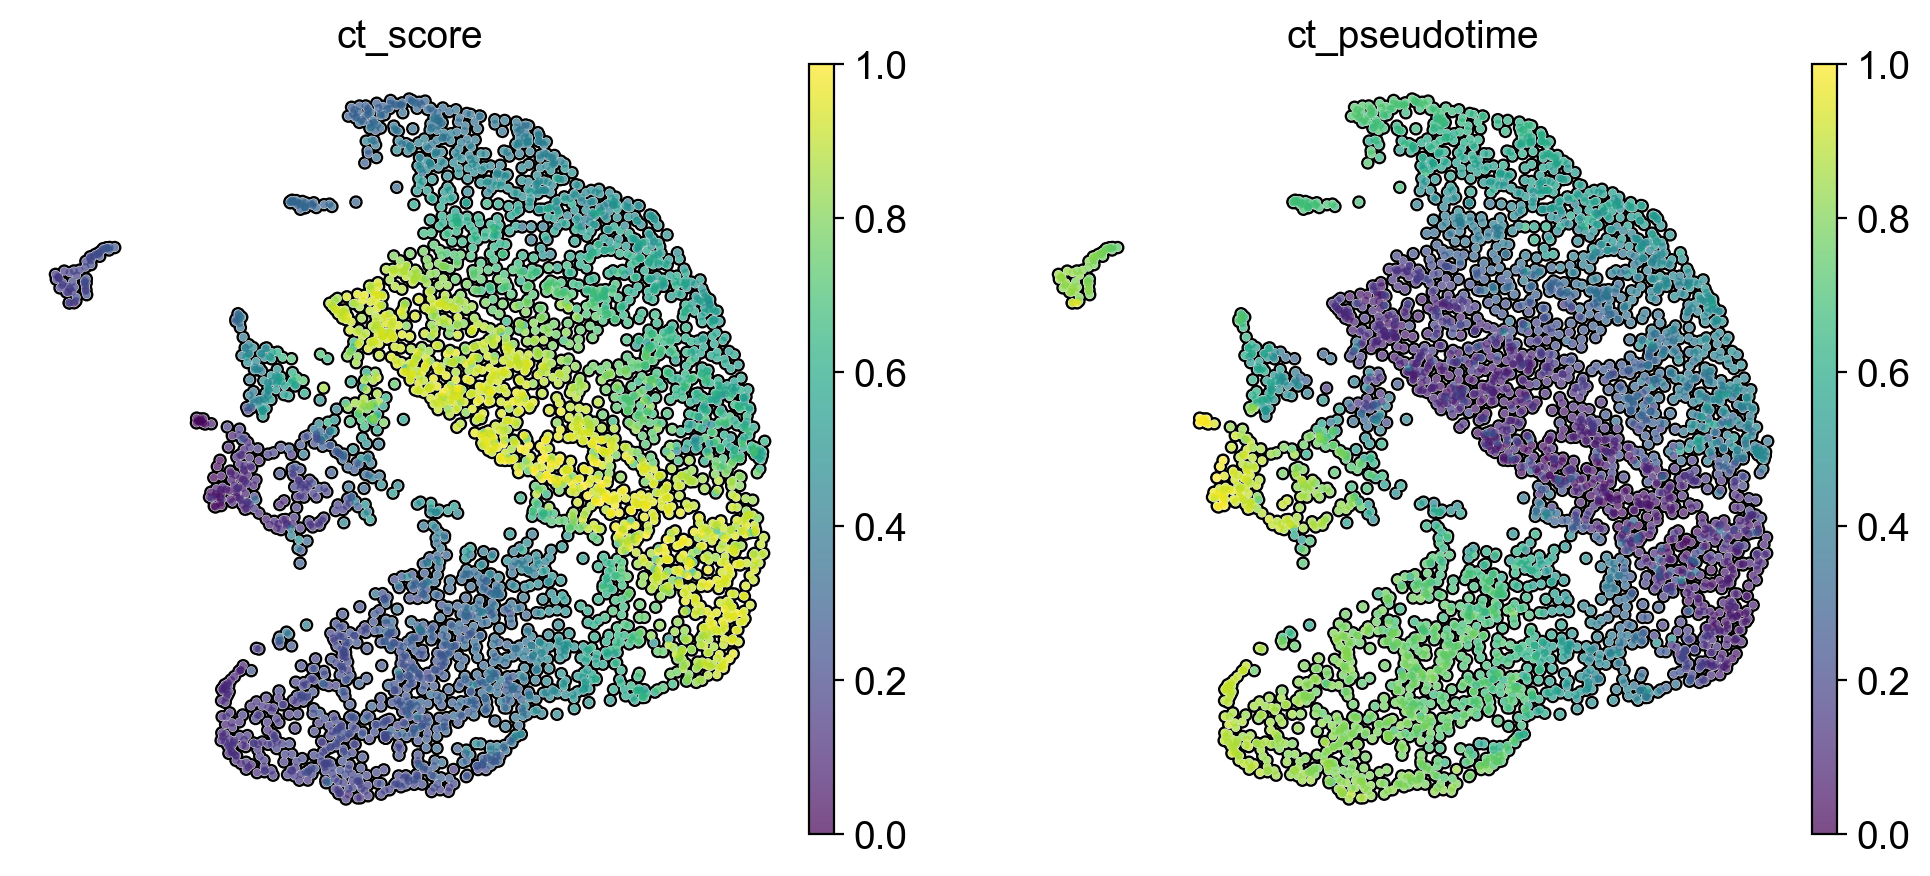

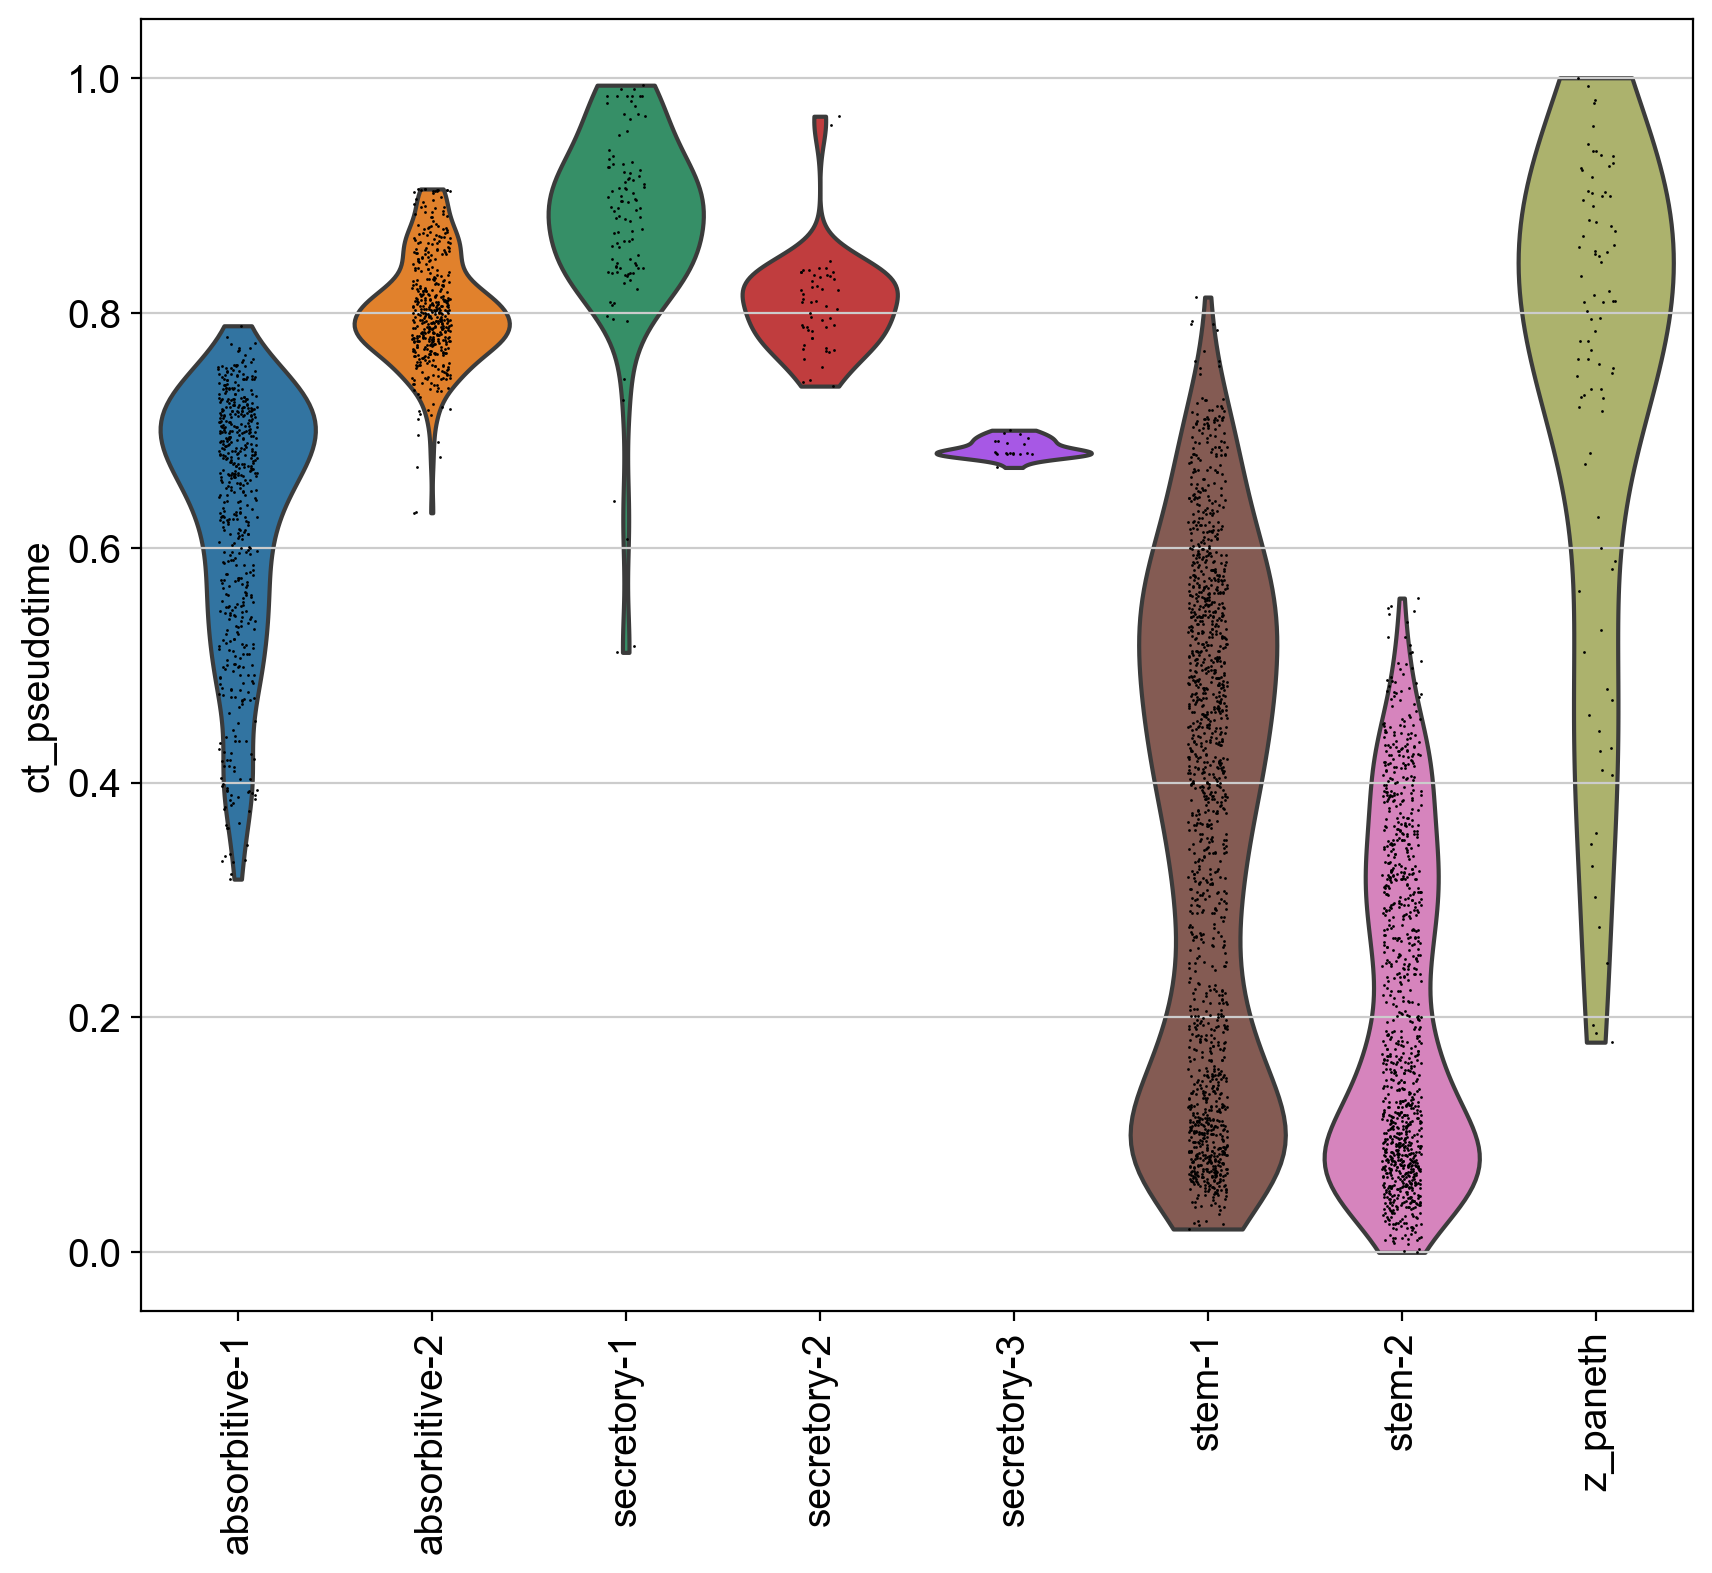

In [10]:
ctk_pseudotime_figure = figures_dir_TE001 + name_prefix + "CytoTRACE_pseudotime.pdf"
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color=['ct_score', 'ct_pseudotime'], show=False, add_outline=True)
    plt.savefig(ctk_pseudotime_figure)

ctk_pseudotime_vln = figures_dir_TE001 + name_prefix + "CytoTRACE_pseudotime_vln.pdf"
with rc_context({'figure.figsize': (8.5, 8.5)}):
    sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="iter_cluster_id_with_paneth", rotation=90, show=False)
    plt.savefig(ctk_pseudotime_vln)

Simulate random walk on the Markov Chain implied by the transition matrix. Starting cells are selected at random. In the first figure, starting cells are selected randomly from all clusters. In figures 2 and 3 they are randomly sampled from the 'stem-1' and 'stem-2' clusters. 100 trajectories are simulated in each Random Walk. Black dots = cells of departure; yellow dots = cells of arrival.

Visualize the projected Transition Probability matrix on the UMAP, with clusters colored at gene expression (panel 1) and protein activity (panel 2). Also, show what we consider as the most differentiated states in the dataset (panel 3).

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/TE001_CytoTRACE_differentiation_cytotrace.svg


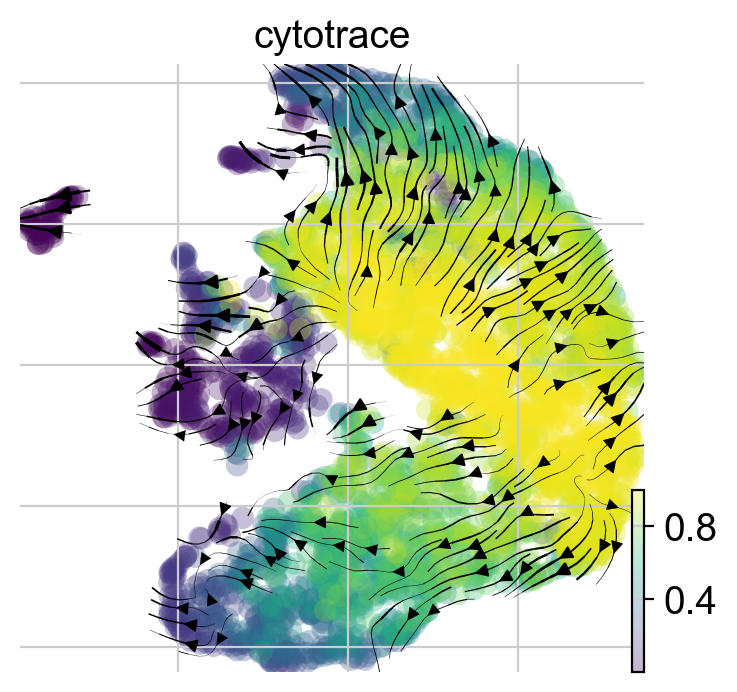

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/TE001_CytoTRACE_differentiation_ges_clusters.svg


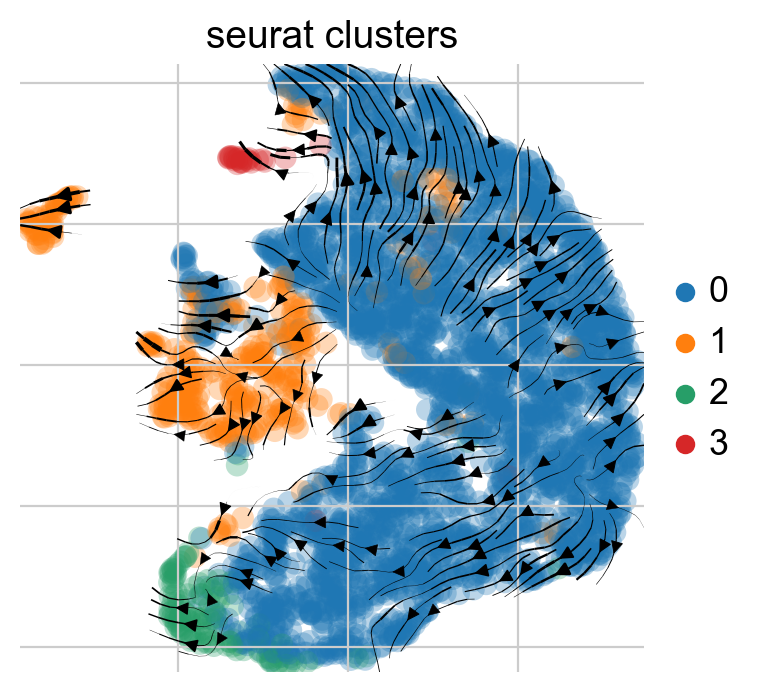

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/TE001_CytoTRACE_differentiation_pa_clusters.svg


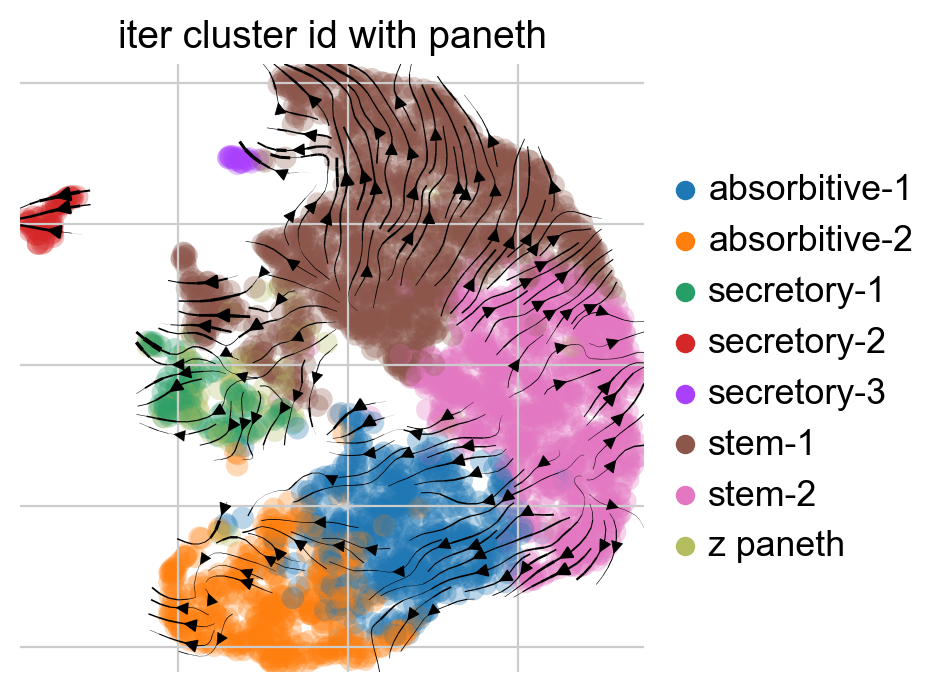

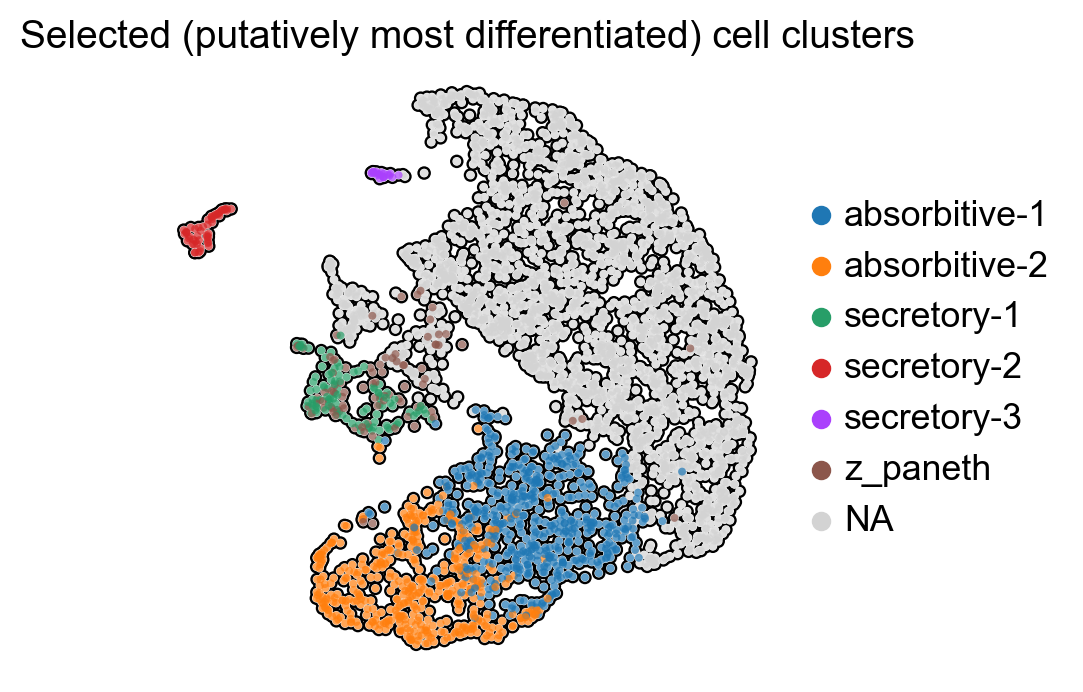

In [11]:
# c.6) visualize the transition matrix
differentiation_figure = figures_dir_TE001 + name_prefix + "CytoTRACE_differentiation_cytotrace.svg"
ctk.plot_projection(basis="umap", color="cytotrace", 
                    legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE001 + name_prefix + "CytoTRACE_differentiation_ges_clusters.svg"
ctk.plot_projection(basis="umap", color="seurat_clusters", 
                    legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE001 + name_prefix + "CytoTRACE_differentiation_pa_clusters.svg"
ctk.plot_projection(basis="umap", color="iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)


# c.7) Check terminal states from annotations
annotated_terminal_states_figure = figures_dir_TE001 + name_prefix + "annotated_terminal_states.pdf"
sc.pl.embedding(adata, basis="umap", color="terminal_states", add_outline=True, title="Selected (putatively most differentiated) cell clusters") 
#####################

Visualize the projected Transition Probability matrix on a scatter plot of secretory vs absorptive and , with clusters colored at gene expression (panel 1) and protein activity (panel 2). Also, show what we consider as the most differentiated states in the dataset (panel 3).

CellRank 2 (advanced) estimator-baed analysis of the Transition Matrix and calculation of the terminal states. Show the real value of the eigenvalues from Schur's decomposition (Figure 1), cell-type distrbution of the terminal states (Figure 2) and visualization of the coarse-grain transition matrix (Figure 3). To change the number of selected macrostate, change `n_macro_CytoTRACE` in the first cell of this notebook.

In [12]:
print('geon

SyntaxError: unterminated string literal (detected at line 1) (532123575.py, line 1)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[16]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:38)


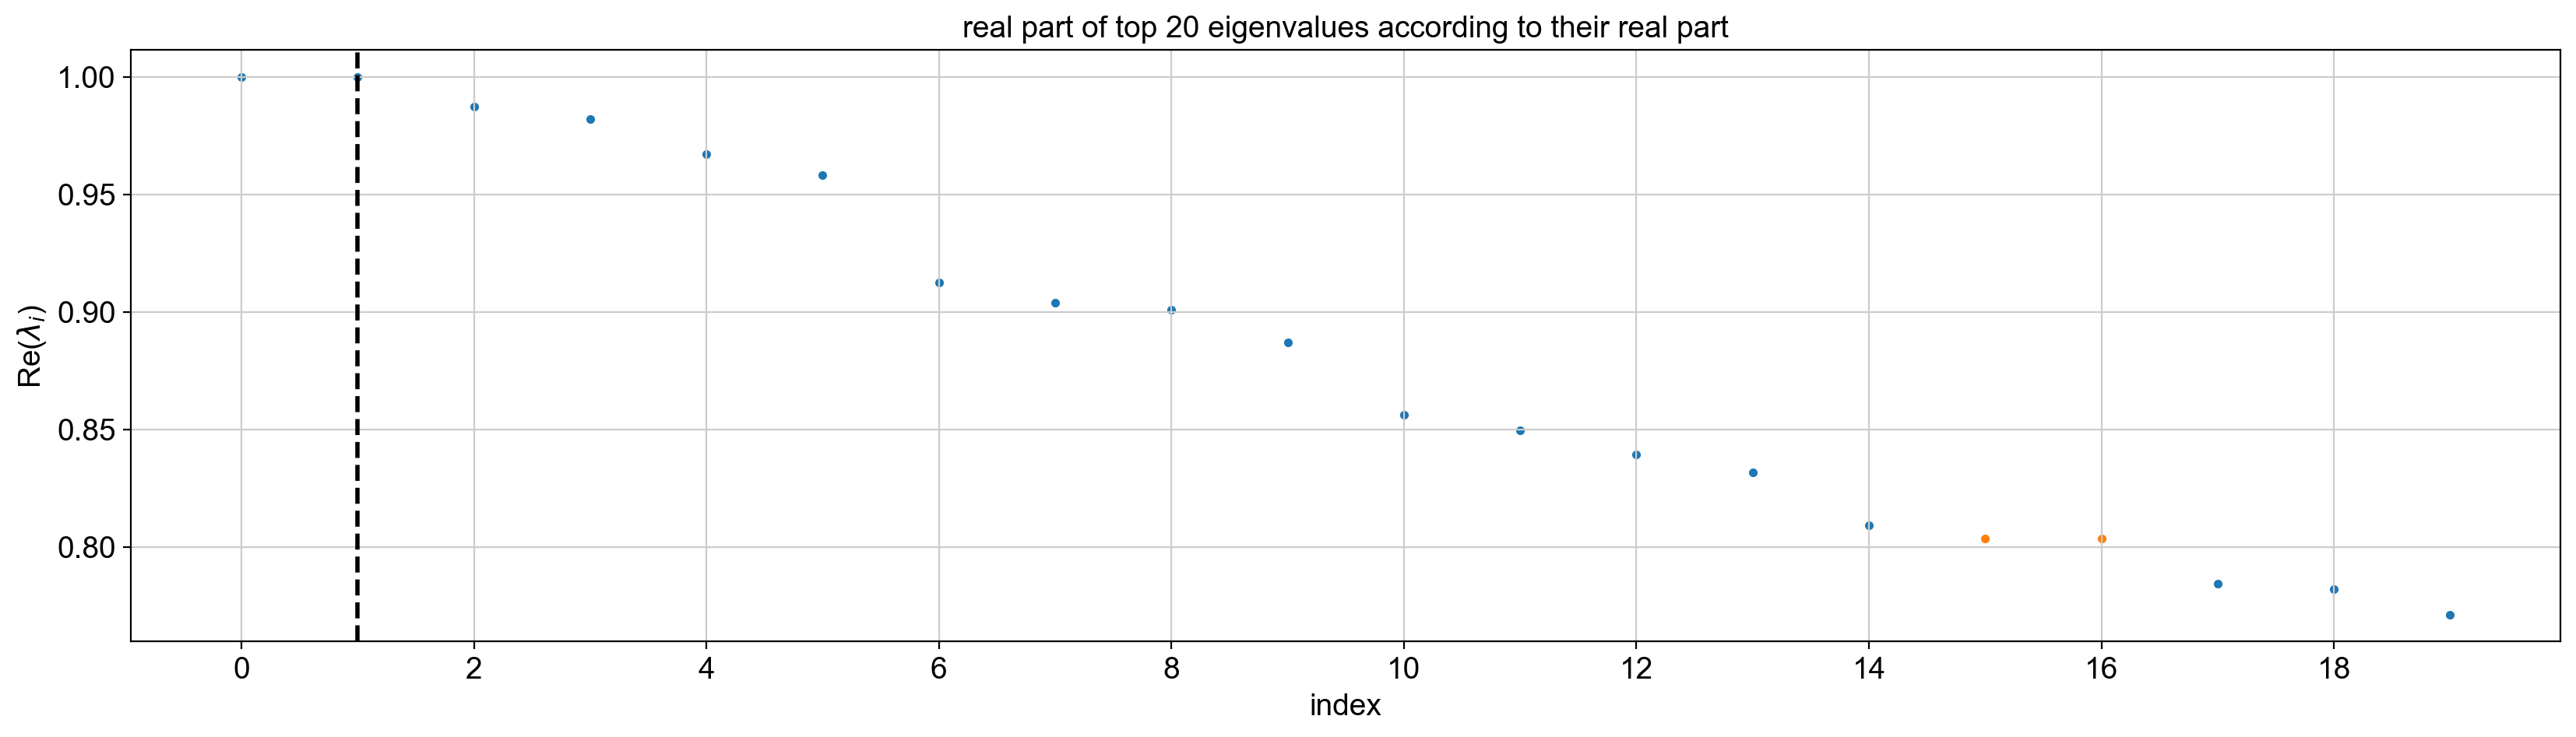

In [13]:
### d) Advanced estimator-based analysis of the CytoTRACE kernel with estimators 
from cellrank.estimators import GPCCA

# d.1) compute estimator
g_ctk = cr.estimators.GPCCA(ctk)
g_ctk.compute_schur(n_components=20) # compute Schur decomposition
eig_figure = figures_dir_TE001 + name_prefix + "GPCCA_eig.pdf"
g_ctk.plot_spectrum(real_only=True, n=None, show_all_xticks=False, save=eig_figure, figsize=(20,5))

Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/TE001_GPCCA_macrostates.pdf


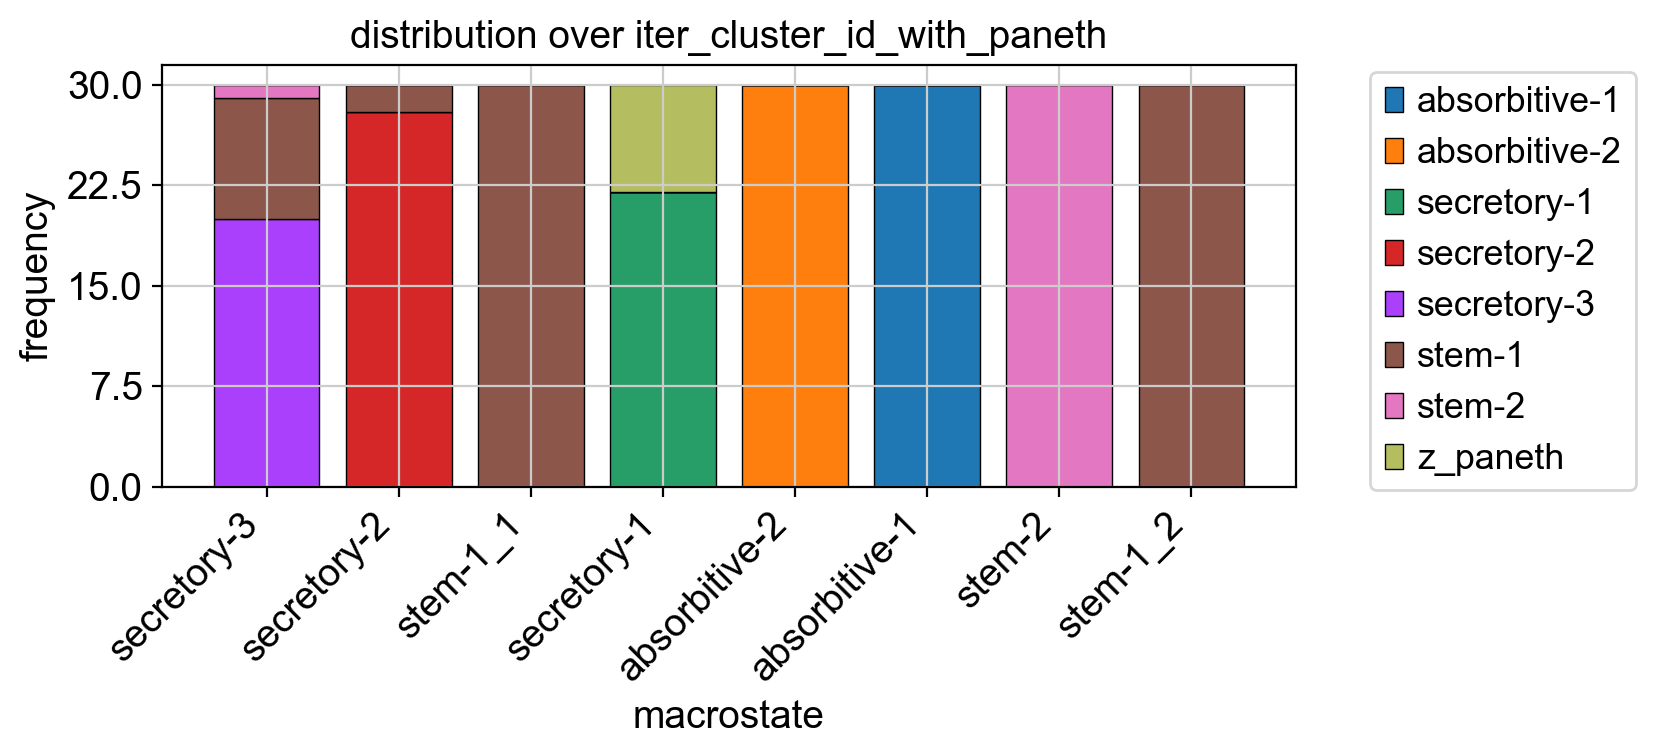

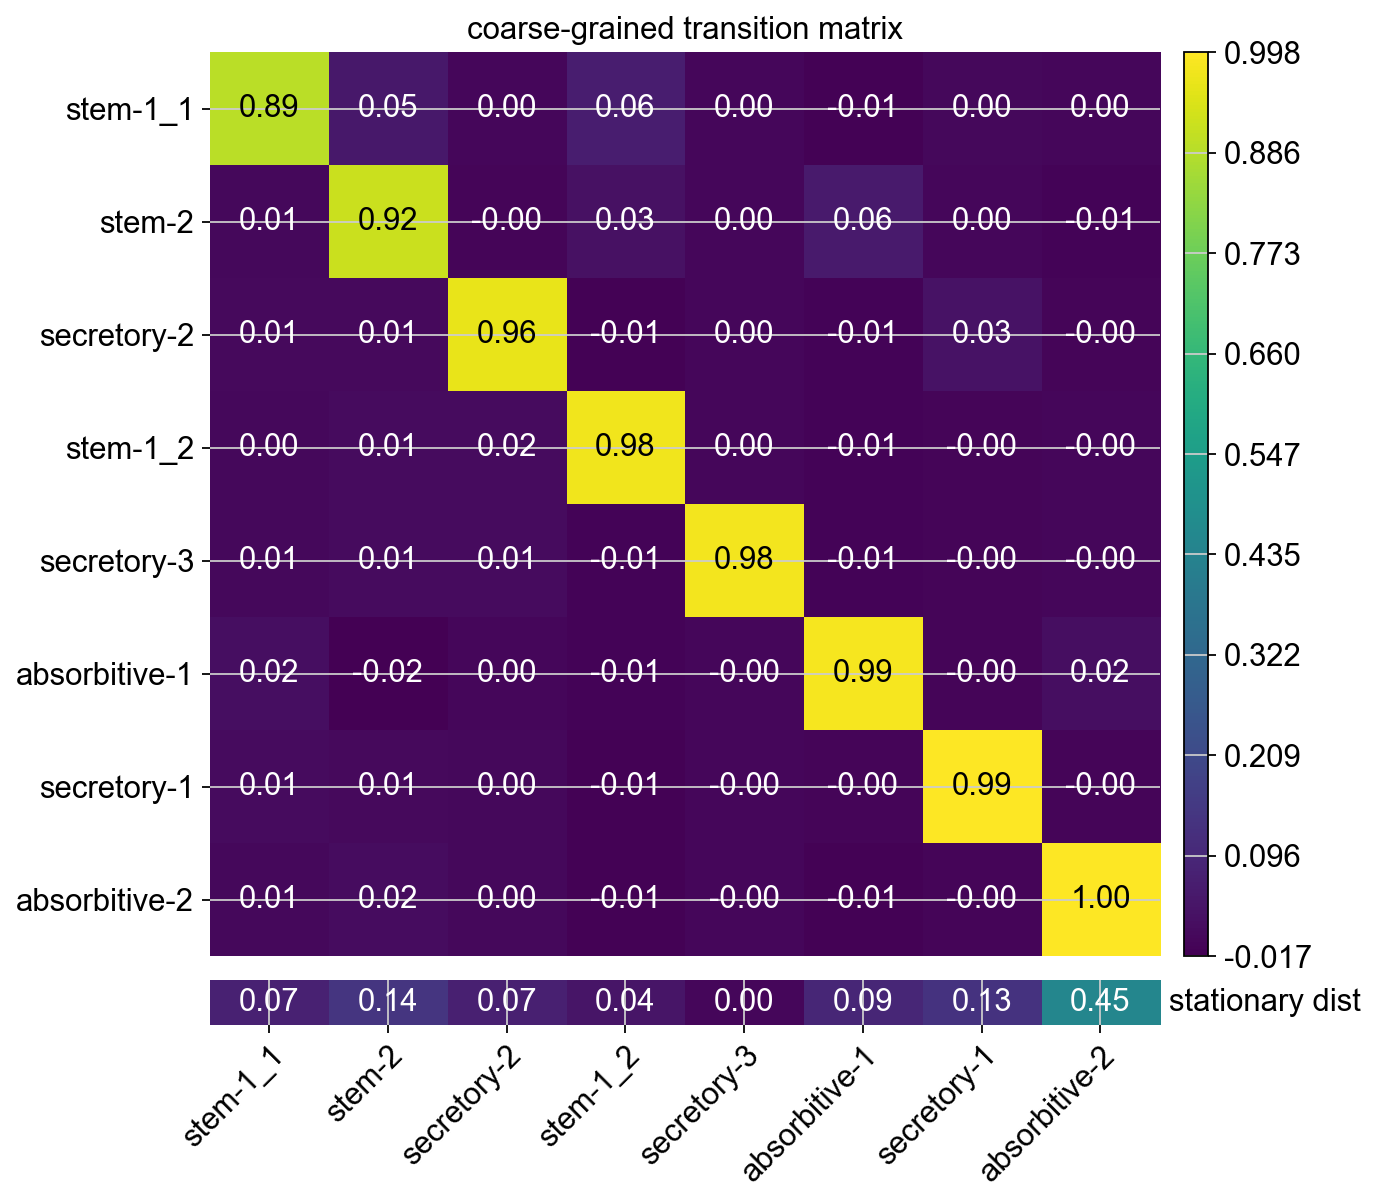

In [14]:
g_ctk.compute_macrostates(n_states=n_macro_CytoTRACE, cluster_key="iter_cluster_id_with_paneth")
macrostates_figure = figures_dir_TE001 + name_prefix + "GPCCA_macrostates.pdf"
g_ctk.plot_macrostates(which="all", legend_loc="right", s=100, save=macrostates_figure, show=False)

macrostates_figure_composition = figures_dir_TE001 + name_prefix + "GPCCA_macrostates_composition.pdf"
g_ctk.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=False, save=macrostates_figure_composition) # composition of each macrostate

coarse_T_figure = figures_dir_TE001 + name_prefix + "GPCCA_coarse_T.pdf"
g_ctk.plot_coarse_T(annotate=True, save=coarse_T_figure) # plot transition matrix

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/TE001_TE001_GPCCA_terminal_states.pdf


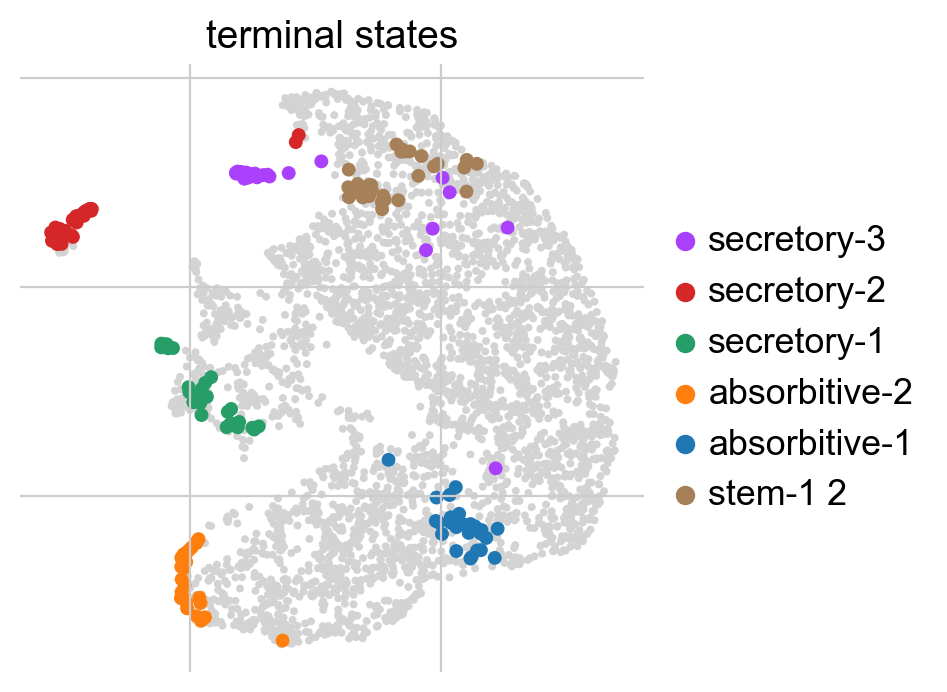

In [15]:
# d.2) compute terminal states
g_ctk.predict_terminal_states()
terminal_states_figure = figures_dir_TE001 + name_prefix + name_prefix + "GPCCA_terminal_states.pdf"
g_ctk.plot_macrostates(which="terminal", legend_loc="right", s=100, save=terminal_states_figure, show=True)

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE001/TE001_TE001_GPCCA_initial_states.pdf


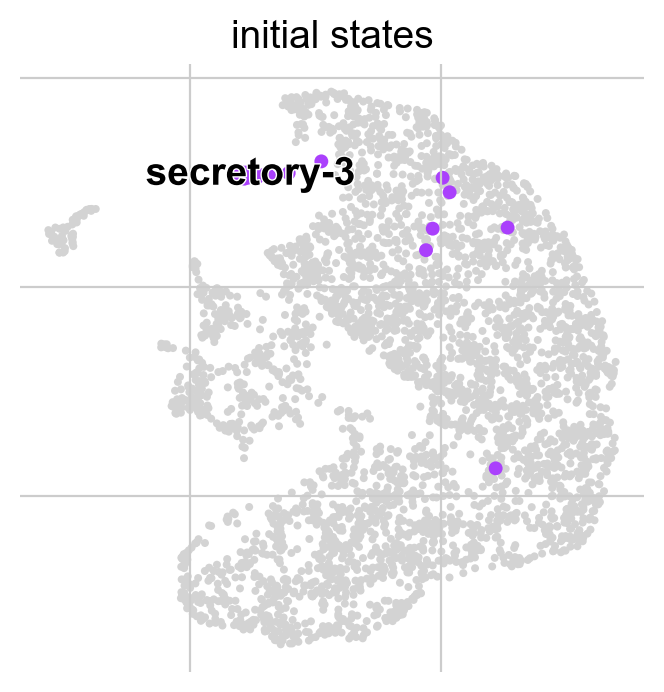

In [16]:
# d.3) predict initial states
g_ctk.predict_initial_states(allow_overlap=True)
initial_states_figure = figures_dir_TE001 + name_prefix + name_prefix + "GPCCA_initial_states.pdf"
g_ctk.plot_macrostates(which="initial", s=100, save =initial_states_figure, show = True)